Generation 1, Best Fitness: 3380.8267179536106
Generation 2, Best Fitness: 3373.125594761854
Generation 3, Best Fitness: 3286.1195203407924
Generation 4, Best Fitness: 3387.059532966819
Generation 5, Best Fitness: 3330.994241069967
Generation 6, Best Fitness: 3278.9287556215927
Generation 7, Best Fitness: 3209.5004502366783
Generation 8, Best Fitness: 3153.304421669094
Generation 9, Best Fitness: 3153.304421669094
Generation 10, Best Fitness: 3103.692986994648
Generation 11, Best Fitness: 3020.1989912595823
Generation 12, Best Fitness: 2989.169428036192
Generation 13, Best Fitness: 2979.1722977346867
Generation 14, Best Fitness: 2968.848325631729
Generation 15, Best Fitness: 2974.4065032554017
Generation 16, Best Fitness: 2889.8096161816893
Generation 17, Best Fitness: 2875.0466914008994
Generation 18, Best Fitness: 2875.0466914008994
Generation 19, Best Fitness: 2850.186485285949
Generation 20, Best Fitness: 2821.724447754224
Generation 21, Best Fitness: 2821.724447754224
Generation 2

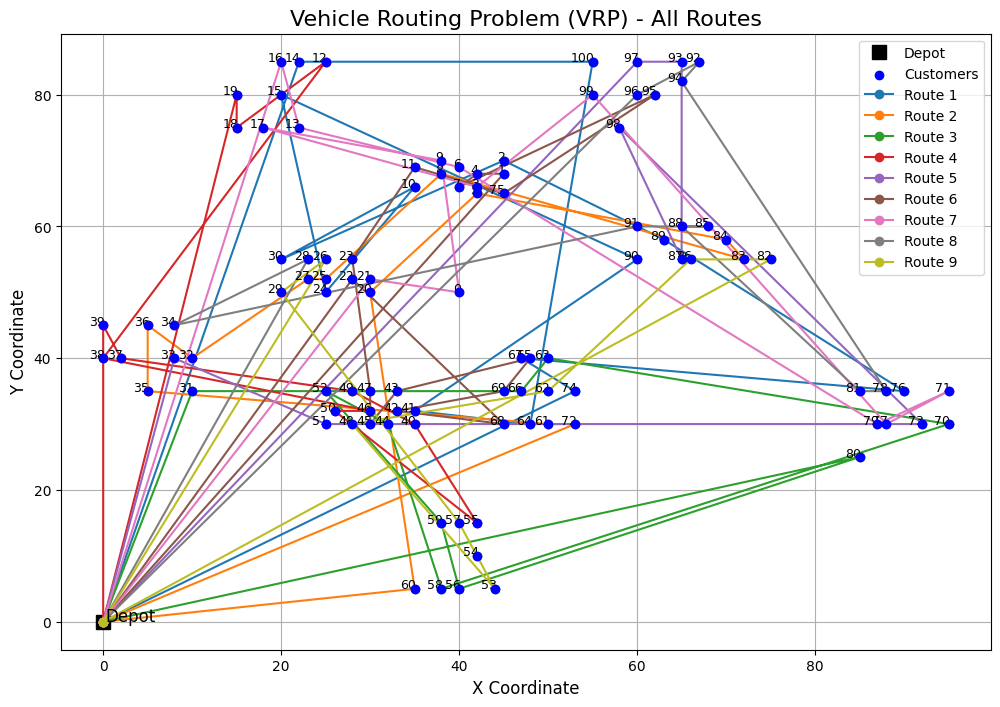

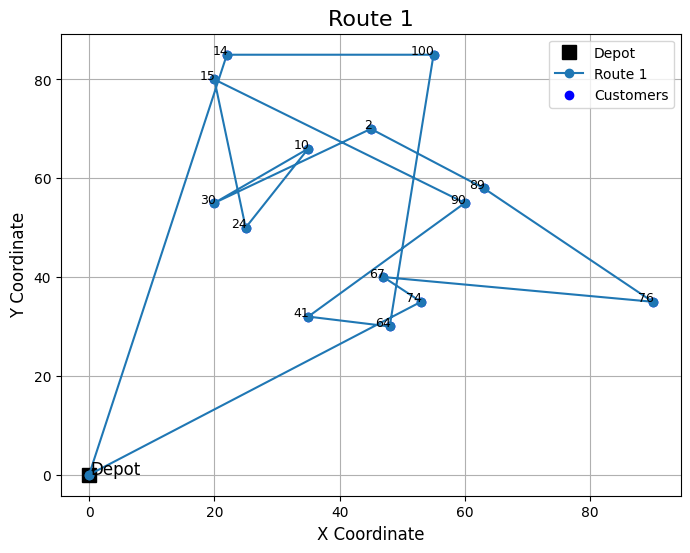

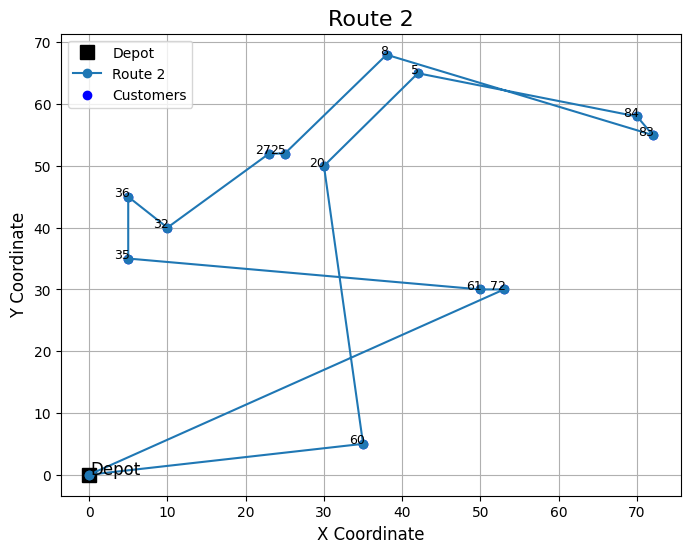

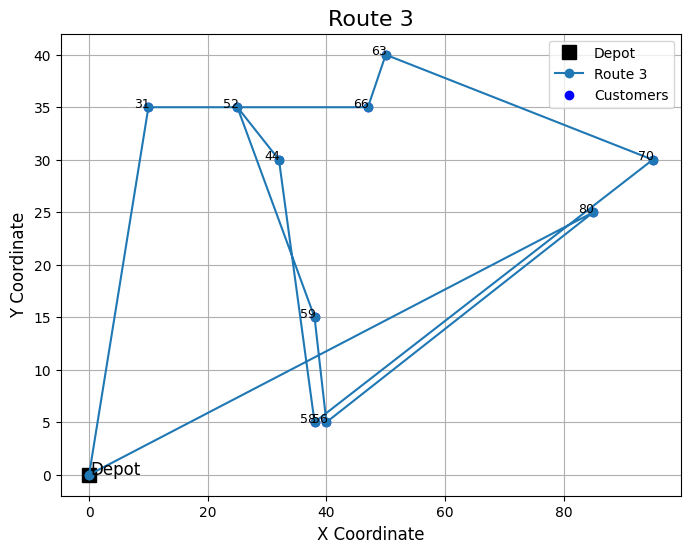

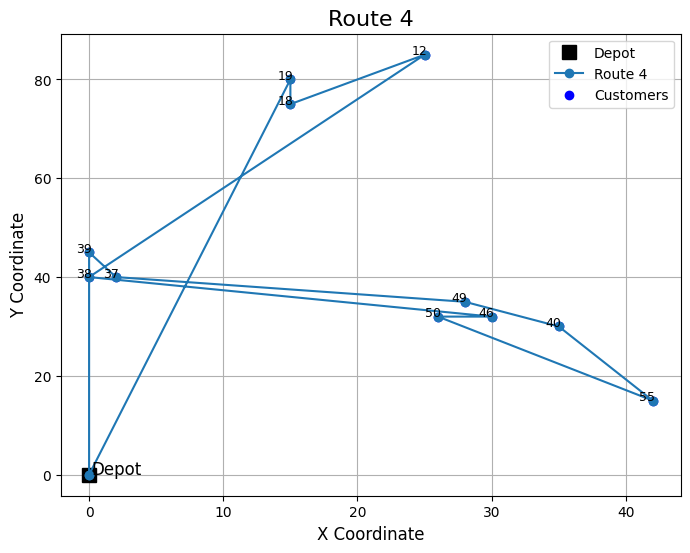

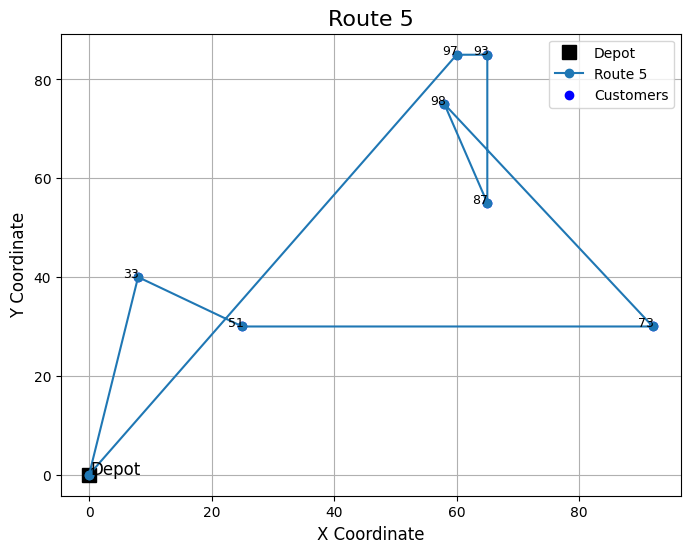

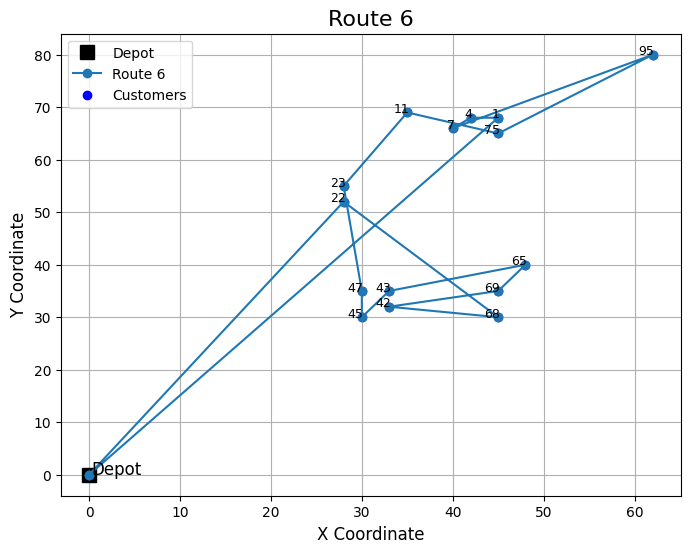

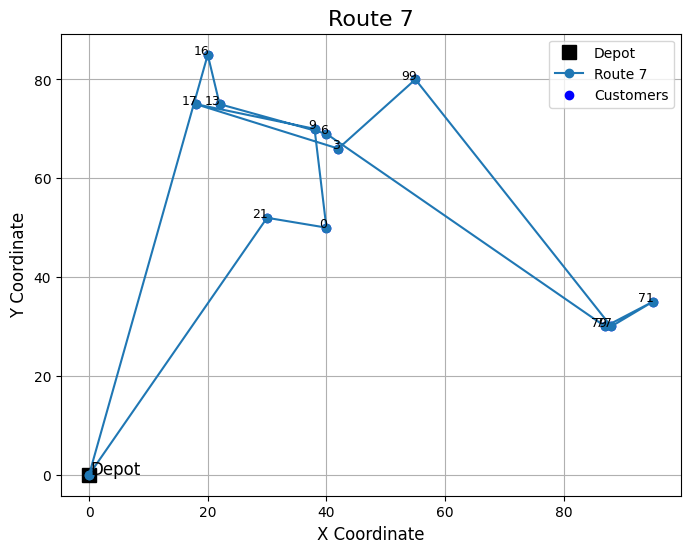

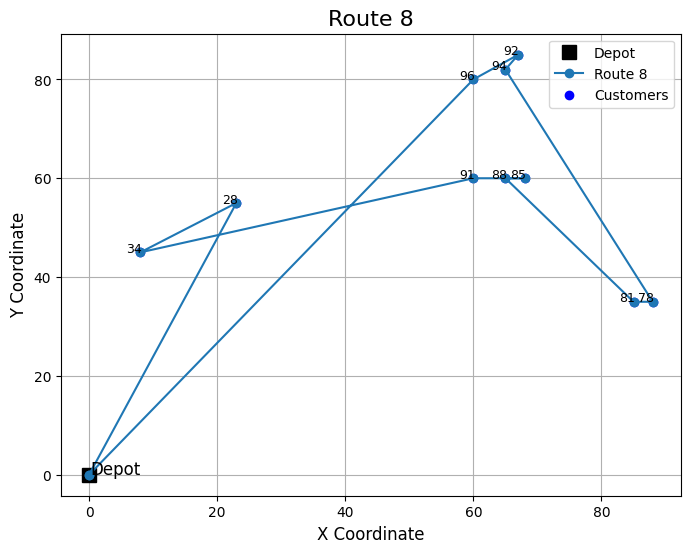

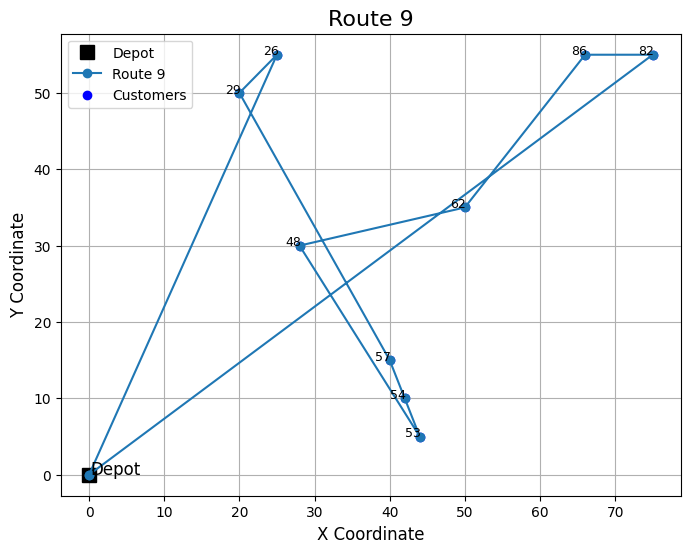

In [1]:
import tkinter as tk
from tkinter import filedialog
import random
import math
import numpy as np
import matplotlib.pyplot as plt


# Function to parse the input file and extract vehicle capacity and customer data
def parse_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    vehicle_capacity = None
    customers = []

    # Extract vehicle capacity by looking for the "CAPACITY" line
    for i, line in enumerate(lines):
        if "CAPACITY" in line:
            # Get the next line for the actual values
            values_line = lines[i + 1].strip().split()
            vehicle_capacity = int(values_line[1])  # Extract the capacity value
            break

    if vehicle_capacity is None:
        raise ValueError("Vehicle capacity not found in the input file.")

    # Locate the start of the customer data
    start_index = None
    for i, line in enumerate(lines):
        if "CUST NO." in line:
            start_index = i + 1  # Data starts immediately after this line
            break

    if start_index is None:
        raise ValueError("Customer data section not found in file.")

    # Parse customer data
    for line in lines[start_index:]:
        data = line.strip().split()
        if len(data) < 7:  # Ignore lines without sufficient data
            continue
        try:
            customer = {
                "id": int(data[0]),
                "x": float(data[1]),
                "y": float(data[2]),
                "demand": int(data[3]),
                "ready_time": int(data[4]),
                "due_date": int(data[5]),
                "service_time": int(data[6])
            }
            customers.append(customer)
        except ValueError:
            # Skip malformed lines
            continue

    return vehicle_capacity, customers


# Function to calculate Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    return math.sqrt((cust1['x'] - cust2['x'])**2 + (cust1['y'] - cust2['y'])**2)


# Function to calculate travel time (using Euclidean distance as a proxy for time)
def calculate_travel_time(cust1, cust2):
    return euclidean_distance(cust1, cust2)


# Genetic Algorithm helpers
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population


def fitness(individual, dist_matrix, vehicle_capacity, customers):
    total_distance = 0
    total_demand = 0
    num_vehicles = 1  # Start with one vehicle

    for i in range(len(individual) - 1):
        current_customer = customers[individual[i]]
        next_customer = customers[individual[i + 1]]

        total_distance += dist_matrix[individual[i]][individual[i + 1]]
        total_demand += current_customer['demand']

        # Check if we exceed the vehicle's capacity
        if total_demand > vehicle_capacity:
            num_vehicles += 1
            total_demand = next_customer['demand']  # Start with the next customer's demand

    return total_distance  # You can modify to add penalty based on vehicles used


def crossover(parent1, parent2):
    # Perform crossover between two parents (partially mapped crossover)
    size = len(parent1)
    child = [-1] * size
    crossover_point = random.randint(0, size)

    # Copy part of the first parent to the child
    for i in range(crossover_point):
        child[i] = parent1[i]

    # Fill the remaining part with genes from the second parent
    for i in range(size):
        if child[i] == -1:
            for gene in parent2:
                if gene not in child:
                    child[i] = gene
                    break
    return child


def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        # Randomly choose two positions to swap
        pos1, pos2 = random.sample(range(len(individual)), 2)
        individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual


def select_parents(population, dist_matrix, vehicle_capacity, customers):
    # Tournament selection: select the best two individuals
    tournament_size = 5
    selected = random.sample(population, tournament_size)
    selected.sort(key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    return selected[0], selected[1]


# Plotting functions
def plot_routes(customers, routes, depot=(0, 0)):
    plt.figure(figsize=(12, 8))
    plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
    plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

    customer_x = [cust['x'] for cust in customers]
    customer_y = [cust['y'] for cust in customers]
    plt.scatter(customer_x, customer_y, c='b', label="Customers", zorder=5)

    for cust in customers:
        plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

    for route_idx, route in enumerate(routes):
        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")

    plt.title('Vehicle Routing Problem (VRP) - All Routes', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_individual_routes(customers, routes, depot=(0, 0)):
    for route_idx, route in enumerate(routes):
        plt.figure(figsize=(8, 6))
        plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
        plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")
        plt.scatter([customers[customer_id]['x'] for customer_id in route],
                    [customers[customer_id]['y'] for customer_id in route],
                    c='b', label="Customers")

        for customer_id in route:
            cust = customers[customer_id]
            plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

        plt.title(f'Route {route_idx + 1}', fontsize=16)
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()


# Extract routes
def extract_routes(best_individual, customers, vehicle_capacity):
    routes = []
    total_demand = 0
    routes.append([best_individual[0]])

    for i in range(1, len(best_individual)):
        current_customer = customers[best_individual[i - 1]]
        next_customer = customers[best_individual[i]]
        total_demand += current_customer['demand']

        if total_demand > vehicle_capacity:
            routes.append([best_individual[i]])
            total_demand = next_customer['demand']
        else:
            routes[-1].append(best_individual[i])

    return routes


# Main solver function
def solve_vrptw(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.1
    population = generate_initial_population(population_size, num_customers)

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population
        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        print(f"Generation {gen + 1}, Best Fitness: {fitness(best_individual, dist_matrix, vehicle_capacity, customers)}")

    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)
    print("\nOptimized Routes:")
    for i, route in enumerate(routes):
        print(f"Vehicle {i + 1}: {route}")

    plot_routes(customers, routes, depot=(0, 0))
    plot_individual_routes(customers, routes, depot=(0, 0))


# Main entry point for file selection and solving
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title="Select VRPTW Input File")
    if file_path:
        solve_vrptw(file_path)

